## Web Scraping/crawling - sequential

Additional reference: https://medium.freecodecamp.org/how-to-scrape-websites-with-python-and-beautifulsoup-5946935d93fe

Here I extracted all the prisoner's info from the first page. To extract all the prisoners information, in the first readin function, I can set max rows to be 250 with the following code:
get_data = { 'max_rows' : '250'}
response = requests.post(url ,data=get_data)

In [21]:
import requests
from bs4 import BeautifulSoup
import time

def readin(url):
    t0=time.time()
    response = requests.get(url)
    html = response.content.decode('ascii')
    elapsed=time.time() - t0
    return BeautifulSoup(html, 'html.parser'), elapsed

In [22]:
soup,time1 = readin('https://report.boonecountymo.org/mrcjava/servlet/SH01_MP.I00290s')
time1

0.38697004318237305

In [23]:
#Sequential data extract from the main page, create dictionary with ID as key, first name, last name, and age

def web_scrape(soup):
    t0= time.time()
    prisoner_dict = {}
    key = []
    last_name = []
    first_name = []
    age = []
    
    #extract information from the first page
    for i in soup.find_all("a", href=lambda href: href and "PERKEP" in href):
        url = i['href'].split('=')
        url_s = url[1].split('&')
        key.append(url_s[0])
        
    for i in soup.findAll('td', {'data-th':'Last Name'}):
        last_name.append(i.get_text(strip = True) [0:])
    for i in soup.findAll('td', {'data-th':'First Name'}):
        first_name.append(i.get_text(strip = True) [0:])
    for i in soup.findAll('td', {'data-th':'Age'}):
        age.append(i.get_text(strip = True) [0:])

    for k in range(len(key)):
        prisoner_dict[key[k]] = {}
        prisoner_dict[key[k]]['Last name'] = last_name [k]
        prisoner_dict[key[k]]['First name'] = first_name [k]
        prisoner_dict[key[k]]['Age'] = age[k]
    elapsed=time.time() - t0
    return prisoner_dict, elapsed


In [24]:
first_dict,time2 = web_scrape(soup)

In [25]:
#Sequential data extract from the details page, create dict with ID as key, charge descriptions, total cases and bails

def additional(soup):
    t0= time.time()
    prisoner_add = {}
    key = []
    total_charge = []
    total_case = []
    total_bail = []
    
    for i in soup.find_all("a", href=lambda href: href and "PERKEP" in href):
        charge_describe = []
        bail = []
        url = i['href'].split('=')
        url_s = url[1].split('&')
        key.append(url_s[0])
        add_url = 'https://report.boonecountymo.org/mrcjava/servlet/SH01_MP.I00500s?PERKEP='+str(url_s[0])
        responsek=requests.get(add_url)
        add_info = responsek.content.decode('ascii')
        add_soup = BeautifulSoup(add_info, 'html.parser')
        
        for i in add_soup.findAll('td', {'data-th':'CHARGE DESCRIPTION'}):
            charge_describe.append(i.get_text(strip = True))
            case_count = len(charge_describe)
        
        total_charge.append(charge_describe)
        total_case.append(case_count)
        
        for i in add_soup.findAll('td', {'data-th':'BAIL'}):
            temp_bail = i.get_text(strip = True)
            if temp_bail:
                bail.append(temp_bail)
            bail_sum = list(map(lambda x: float(x.replace(',','')),bail))
        
        total_bail.append(sum(bail_sum))
    
    for k in range(len(key)):
        prisoner_add[key[k]] = {}
        prisoner_add[key[k]]['Charge description'] = total_charge[k]
        prisoner_add[key[k]]['Total case'] = total_case[k]
        prisoner_add[key[k]]['Total bail'] = total_bail[k]
    
    crime_4_plot = []
    #flatten out the list of crime descriptions for plot later
    for i in total_charge:
        crime_4_plot.extend(i)
    elapsed=time.time() - t0
    return prisoner_add, crime_4_plot, elapsed

In [26]:
new, crime, time3 = additional(soup)

In [27]:
#Merge the two dictionaries together to return the required information for each prisoner
def merge(dict1, dict2):
    t0= time.time()
    for key in dict1.keys():
        if key in dict2.keys():
            dict1[key]['Charge description'] = dict2[key]['Charge description']
            dict1[key]['Total case'] = dict2[key]['Total case']
            dict1[key]['Total bail'] = dict2[key]['Total bail']
    elapsed=time.time() - t0
    return dict1, elapsed

In [28]:
final_dict,time4 = merge(first_dict, new)
print(final_dict)

{'66343': {'Last name': 'AARON', 'First name': 'KEVIN', 'Age': '23', 'Charge description': ['DOMESTIC ASSAULT - 2'], 'Total case': 1, 'Total bail': 30000.0}, '77695': {'Last name': 'ADAM', 'First name': 'OMER', 'Age': '29', 'Charge description': ['SEX ABUSE-2ND DEG', 'ASSAULT - 4TH - C'], 'Total case': 2, 'Total bail': 15000.0}, '51443': {'Last name': 'AKERS', 'First name': 'BRANDEN', 'Age': '32', 'Charge description': ['P&P VIOLATION'], 'Total case': 1, 'Total bail': 5000.0}, '19022': {'Last name': 'ALLEN', 'First name': 'WILLIAM', 'Age': '55', 'Charge description': ['FAIL REG AS SEX OFFE'], 'Total case': 1, 'Total bail': 10000.0}, '66544': {'Last name': 'ANDERSON', 'First name': 'RICHARD', 'Age': '24', 'Charge description': ['COMMIT', 'P&P VIOLATION'], 'Total case': 2, 'Total bail': 5000.0}, '78424': {'Last name': 'AVALOS-AVALOS', 'First name': 'JOSE', 'Age': '19', 'Charge description': ['BURGLARY - 2ND DEGRE', 'TAMPERING WITH MOTOR'], 'Total case': 2, 'Total bail': 20000.0}, '4285':

**Execution times**

In [29]:
time_seq = time1 + time2 + time3 + time4
print("Total time taken for sequential search is:", time_seq)

Total time taken for sequential search is: 38.6560914516449


**Provide a plot that shows the top 10 crime types by description and occurrence percentage**

In [30]:
#create a histogram using crime_4_plot list from def additional(soup)

#first, create a dictionary that returns the count of each charge description
dict = {}

for i in crime:
    if i in dict:
        dict[i] += 1
    else:
        dict[i] = 1
print(dict)

{'DOMESTIC ASSAULT - 2': 3, 'SEX ABUSE-2ND DEG': 1, 'ASSAULT - 4TH - C': 1, 'P&P VIOLATION': 8, 'FAIL REG AS SEX OFFE': 1, 'COMMIT': 8, 'BURGLARY - 2ND DEGRE': 1, 'TAMPERING WITH MOTOR': 9, 'PEACE DISTURBANCE': 1, 'DIST.MANU.OR POSSES.': 1, 'RESISTING ARREST': 2, 'FAILURE TO APPEAR': 11, 'OUT/COUNTY WARRANT': 14, 'POSSESS CONTROL SUBS': 6, 'RESISTING/INTERFERIN': 5, 'RESIST/INTERFERE ARR': 2, 'ASSAULT - 4TH - A': 3, 'ROBBERY - 1ST DEGREE': 3, 'BURGLARY 1ST DEGREE': 3, 'ARMED CRIMINAL ACTIO': 4, 'BURGLARY 1ST DEG': 1, 'DOM ASSLT-4/1ST OFF': 3, 'US MARSHAL HOLD': 2, 'DOM ASSLT-2ND-1S OFF': 1, 'STEALING': 1, 'ATTEMPT BURGLARY 1ST': 1, 'PROP. DAMAGE 2ND DEG': 1, 'F/T REG AS SEX OFFEN': 1, 'SEX MISC-1ST DEG-1ST': 1, 'WRIT': 1, 'KIDNAPPING': 1, 'PROPERTY DAMAGE - 2N': 3, 'DOMESTIC ASSAULT - 3': 1, 'FAILURE TO FOLLOW JU': 5, 'BOND REVOCATION': 9, 'TERRORIST THREAT - 1': 1, 'TERRORIST THREAT - 2': 1, 'MURDER 2ND DEGREE-F': 1, 'UNLAWFUL POSS FIREA': 3, 'FRAUD USE CR DEV M': 1, 'STEALING - ALL O

In [31]:
#X axis - Take the top 10 crime types from the dict above
x_label=sorted(dict,key=dict.get, reverse=True)[:10]
#print(x_label)

crime_total = len(crime)
#print (crime_total)

#Y axis - calculate the percentage of the top 10 crime types
y = []
for i in x_label:
    a= dict[i]/crime_total*100
    y.append(a)

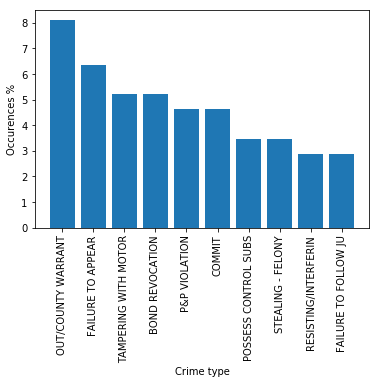

In [32]:
import matplotlib.pyplot as plt

x=[1,2,3,4,5,6,7,8,9,10]

a= plt.bar(x,y)
plt.xticks(x, x_label, rotation='vertical')

plt.ylabel('Occurences %')
plt.xlabel('Crime type')
plt.show()